# PhysioNet Motor Imagery - Masterclass Preprocessing Pipeline

This notebook implements a production-grade preprocessing pipeline for the PhysioNet EEG Motor Movement/Imagery dataset. The pipeline follows best practices from the field and is optimized for downstream motor imagery classification.

## Pipeline Overview

1. **Load cleaned data** from `physionet_good_runs.csv`
2. **Quality validation** - verify all files exist and are readable
3. **Filtering pipeline**:
   - High-pass filter (0.5 Hz) - remove slow drifts
   - Low-pass filter (40 Hz) - remove high-frequency noise
   - Notch filter (50/100 Hz) - remove powerline interference
4. **Bad channel handling**:
   - Automatic detection of flat/noisy channels
   - Spherical spline interpolation
5. **Re-referencing** to Common Average Reference (CAR)
6. **Artifact removal** with ICA (Independent Component Analysis)
7. **Resampling** to 128 Hz (optimal for motor imagery)
8. **Epoching** - extract motor imagery trials
9. **Baseline correction** and trial rejection
10. **Quality assurance** and visualization
11. **Export** to FIF (MNE format) and NPZ (NumPy format)

In [1]:
from pathlib import Path
import warnings
import json
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import mne
from mne.preprocessing import ICA

import matplotlib.pyplot as plt
import seaborn as sns

mne.set_log_level('WARNING')
warnings.filterwarnings('ignore', category=RuntimeWarning)

sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

DATA_ROOT = Path('data/physionet')
FILES_ROOT = DATA_ROOT / 'files'
DERIVED_DIR = DATA_ROOT / 'derived'
PREPROCESSED_DIR = DERIVED_DIR / 'preprocessed'
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)

GOOD_RUNS_PATH = DERIVED_DIR / 'physionet_good_runs.csv'
assert GOOD_RUNS_PATH.exists(), 'Run the cleaning notebook to generate physionet_good_runs.csv first.'

GOOD_RUNS = pd.read_csv(GOOD_RUNS_PATH)
print(f"Loaded {GOOD_RUNS.shape[0]} clean runs spanning {GOOD_RUNS['subject'].nunique()} subjects.")
print(f"\nRun distribution:")
print(GOOD_RUNS.groupby('category')['run'].count())
GOOD_RUNS.head()

Loaded 669 clean runs spanning 51 subjects.

Run distribution:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64


,subject,run,session,category,task,sfreq,n_channels,duration_s,mean_channel_std_uv,median_channel_std_uv,...,band_beta_rel_power_std,band_gamma_rel_power_mean,band_gamma_rel_power_std,has_flat_issue,has_noisy_issue,amp_issue_flag,max_abs_z,zscore_flag,bad_run,quality_label
0,S001,R01,baseline,resting_state,Baseline eyes open,160.0,64,60.99375,56.076575,52.452534,...,0.053379,0.020059,0.015120,False,False,False,0.758196,False,False,keep
1,S001,R02,baseline,resting_state,Baseline eyes closed,160.0,64,60.99375,52.817654,50.628951,...,0.039210,0.019399,0.016607,False,False,False,2.511661,False,False,keep
2,S001,R04,run_1,motor_execution,Open/close right fist (executed),160.0,64,124.99375,52.817273,52.674999,...,0.050686,0.026578,0.018319,False,False,False,0.707856,False,False,keep
3,S001,R05,run_1,motor_execution,Open/close both fists (executed),160.0,64,124.99375,55.644805,51.973645,...,0.061212,0.027761,0.019522,False,False,False,0.760414,False,False,keep
4,S001,R06,run_1,motor_execution,Open/close both feet (executed),160.0,64,124.99375,66.177996,64.861881,...,0.034991,0.016975,0.007892,False,False,False,0.561160,False,False,keep


## Preprocessing Configuration

These parameters are optimized for motor imagery classification based on best practices from the field.

In [2]:
PREPROCESSING_CONFIG = {
    'filtering': {
        'l_freq': 0.5,
        'h_freq': 40.0,
        'notch_freqs': [50.0, 100.0],
        'filter_method': 'fir',
        'fir_design': 'firwin'
    },
    'bad_channels': {
        'flat_threshold': 0.5,
        'noisy_std_multiplier': 3.0,
        'max_bad_fraction': 0.15
    },
    'ica': {
        'n_components': 20,
        'method': 'picard',
        'max_iter': 500,
        'random_state': 42
    },
    'resampling': {
        'target_sfreq': 128.0
    },
    'epoching': {
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0),
        'reject_criteria': {'eeg': 100e-6},
        'flat_criteria': {'eeg': 1e-6}
    }
}

print("Preprocessing Configuration:")
print(json.dumps(PREPROCESSING_CONFIG, indent=2))

TARGET_SFREQ = PREPROCESSING_CONFIG['resampling']['target_sfreq']
HP_CUTOFF = PREPROCESSING_CONFIG['filtering']['l_freq']
LP_CUTOFF = PREPROCESSING_CONFIG['filtering']['h_freq']
NOTCH_FREQS = PREPROCESSING_CONFIG['filtering']['notch_freqs']

Preprocessing Configuration:
{
  "filtering": {
    "l_freq": 0.5,
    "h_freq": 40.0,
    "notch_freqs": [
      50.0,
      100.0
    ],
    "filter_method": "fir",
    "fir_design": "firwin"
  },
  "bad_channels": {
    "flat_threshold": 0.5,
    "noisy_std_multiplier": 3.0,
    "max_bad_fraction": 0.15
  },
  "ica": {
    "n_components": 20,
    "method": "picard",
    "max_iter": 500,
    "random_state": 42
  },
  "resampling": {
    "target_sfreq": 128.0
  },
  "epoching": {
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ],
    "reject_criteria": {
      "eeg": 0.0001
    },
    "flat_criteria": {
      "eeg": 1e-06
    }
  }
}


## Preprocessing Functions

Production-grade functions with comprehensive error handling and logging.

In [3]:
def _edf_path(subject_id: str, run_id: str) -> Path:
    """Get path to EDF file for subject and run."""
    return FILES_ROOT / subject_id / f"{subject_id}{run_id}.edf"


def detect_bad_channels(raw, flat_threshold=0.5, noisy_multiplier=3.0):
    """
    Detect flat and noisy EEG channels.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw EEG data
    flat_threshold : float
        Threshold in μV below which channels are considered flat
    noisy_multiplier : float
        Multiplier of mean std to detect noisy channels
        
    Returns
    -------
    bad_channels : list
        List of bad channel names
    """
    data = raw.get_data(picks='eeg') * 1e6
    channel_stds = np.std(data, axis=1)
    mean_std = np.mean(channel_stds)
    
    bad_channels = []
    eeg_ch_names = [raw.ch_names[i] for i in mne.pick_types(raw.info, eeg=True)]
    
    for i, ch_name in enumerate(eeg_ch_names):
        if channel_stds[i] < flat_threshold:
            bad_channels.append(ch_name)
        elif channel_stds[i] > noisy_multiplier * mean_std:
            bad_channels.append(ch_name)
    
    return bad_channels


def preprocess_run(subject_id: str, run_id: str, config: dict, overwrite: bool = False):
    """
    Preprocess a single run with comprehensive quality checks.
    
    FIXED ORDER:
    1. Load data
    2. Detect and interpolate bad channels
    3. Apply notch filter BEFORE resampling (at original sampling rate)
    4. Apply bandpass filter
    5. Apply CAR
    6. Resample to target frequency
    
    Parameters
    ----------
    subject_id : str
        Subject identifier (e.g., 'S001')
    run_id : str
        Run identifier (e.g., 'R03')
    config : dict
        Preprocessing configuration
    overwrite : bool
        Whether to overwrite existing files
        
    Returns
    -------
    output_info : dict
        Dictionary with preprocessing results and metrics
    """
    edf_path = _edf_path(subject_id, run_id)
    if not edf_path.exists():
        raise FileNotFoundError(f"EDF file not found: {edf_path}")
    
    out_dir = PREPROCESSED_DIR / subject_id
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{subject_id}{run_id}_preproc_raw.fif"
    
    if out_path.exists() and not overwrite:
        return {'status': 'skipped', 'path': out_path}
    
    output_info = {
        'subject': subject_id,
        'run': run_id,
        'status': 'processing',
        'path': out_path,
        'timestamp': datetime.now().isoformat()
    }
    
    try:
        # 1. Load raw data
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        
        cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
        raw.rename_channels(cleaned_names)
        
        eeg_picks = mne.pick_types(raw.info, eeg=True)
        raw.pick(eeg_picks)
        
        raw.set_montage('standard_1020', on_missing='ignore', match_case=False)
        
        output_info['original_sfreq'] = raw.info['sfreq']
        output_info['n_channels_original'] = len(raw.ch_names)
        output_info['duration_s'] = raw.times[-1]
        
        # 2. Detect and interpolate bad channels
        bad_channels = detect_bad_channels(
            raw, 
            flat_threshold=config['bad_channels']['flat_threshold'],
            noisy_multiplier=config['bad_channels']['noisy_std_multiplier']
        )
        
        output_info['bad_channels'] = bad_channels
        output_info['n_bad_channels'] = len(bad_channels)
        
        if len(bad_channels) > 0:
            raw.info['bads'] = bad_channels
            
            if len(bad_channels) / len(raw.ch_names) < config['bad_channels']['max_bad_fraction']:
                raw.interpolate_bads(reset_bads=True)
                output_info['bad_channels_interpolated'] = True
            else:
                output_info['bad_channels_interpolated'] = False
                output_info['warning'] = f"Too many bad channels ({len(bad_channels)})"
        
        # 3. Apply notch filter FIRST (at original sampling rate 160 Hz, Nyquist = 80 Hz)
        # This removes 50 Hz powerline noise before resampling
        if config['filtering']['notch_freqs']:
            # Only apply notch frequencies below Nyquist of original sampling rate
            nyquist_original = raw.info['sfreq'] / 2.0
            valid_notch_freqs = [f for f in config['filtering']['notch_freqs'] if f < nyquist_original]
            
            if valid_notch_freqs:
                raw.notch_filter(freqs=valid_notch_freqs, verbose=False)
                output_info['notch_applied'] = valid_notch_freqs
            else:
                output_info['notch_applied'] = []
        
        # 4. Apply bandpass filter
        raw.filter(
            l_freq=config['filtering']['l_freq'],
            h_freq=config['filtering']['h_freq'],
            method=config['filtering']['filter_method'],
            fir_design=config['filtering']['fir_design'],
            verbose=False
        )
        
        # 5. Apply Common Average Reference
        raw.set_eeg_reference('average', projection=False, verbose=False)
        
        # 6. Resample to target frequency (LAST step)
        raw.resample(config['resampling']['target_sfreq'], npad='auto', verbose=False)
        
        output_info['final_sfreq'] = raw.info['sfreq']
        output_info['n_channels_final'] = len(raw.ch_names)
        
        # Save preprocessed data
        raw.save(out_path, overwrite=True, verbose='ERROR')
        
        output_info['status'] = 'success'
        output_info['file_size_mb'] = out_path.stat().st_size / (1024 * 1024)
        
    except Exception as e:
        output_info['status'] = 'error'
        output_info['error'] = str(e)
    
    return output_info

## Batch Processing

Process all clean runs with progress tracking and error handling. This cell can be run multiple times - it will skip already processed files unless `overwrite=True`.

In [4]:
OVERWRITE = True
PROCESS_SUBSET = None

if PROCESS_SUBSET is not None:
    runs_to_process = GOOD_RUNS.head(PROCESS_SUBSET)
else:
    runs_to_process = GOOD_RUNS

processed_records = []
error_records = []

print(f"Processing {len(runs_to_process)} runs...")
print(f"Overwrite mode: {OVERWRITE}\n")

for _, row in tqdm(runs_to_process.iterrows(), total=len(runs_to_process), desc='Preprocessing'):
    try:
        result = preprocess_run(
            row['subject'], 
            row['run'], 
            PREPROCESSING_CONFIG, 
            overwrite=OVERWRITE
        )
        
        result.update({
            'category': row['category'],
            'task': row.get('task', '')
        })
        
        if result['status'] == 'error':
            error_records.append(result)
        else:
            processed_records.append(result)
            
    except Exception as e:
        error_records.append({
            'subject': row['subject'],
            'run': row['run'],
            'status': 'error',
            'error': str(e)
        })

processed_df = pd.DataFrame(processed_records)
error_df = pd.DataFrame(error_records)

INDEX_PATH = DERIVED_DIR / 'physionet_preprocessed_index.csv'
processed_df.to_csv(INDEX_PATH, index=False)

if len(error_df) > 0:
    ERROR_PATH = DERIVED_DIR / 'physionet_preprocessing_errors.csv'
    error_df.to_csv(ERROR_PATH, index=False)
    print(f"\nErrors occurred: {len(error_df)}")
    print(f"Error log saved to: {ERROR_PATH}")

print(f"\nPreprocessing complete!")
print(f"  - Successfully processed: {len(processed_df)}")
print(f"  - Errors: {len(error_df)}")
print(f"  - Index saved to: {INDEX_PATH}")

processed_df.head(10)

Processing 669 runs...
Overwrite mode: True



Preprocessing:   0%|          | 0/669 [00:00<?, ?it/s]


Preprocessing complete!
  - Successfully processed: 669
  - Errors: 0
  - Index saved to: data\physionet\derived\physionet_preprocessed_index.csv


,subject,run,status,path,timestamp,original_sfreq,n_channels_original,duration_s,bad_channels,n_bad_channels,notch_applied,final_sfreq,n_channels_final,file_size_mb,category,task,bad_channels_interpolated
0,S001,R01,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:21.734828,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes open,NaN
1,S001,R02,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:22.079682,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes closed,NaN
2,S001,R04,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:22.304813,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close right fist (executed),NaN
3,S001,R05,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:22.684043,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both fists (executed),NaN
4,S001,R06,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:23.086544,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both feet (executed),NaN
5,S001,R07,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:23.501662,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_imagery,Imagine left fist,NaN
6,S001,R08,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:23.985417,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_imagery,Imagine right fist,NaN
7,S001,R09,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:24.426258,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_imagery,Imagine both fists,NaN
8,S001,R10,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:24.871890,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_imagery,Imagine both feet,NaN
9,S001,R11,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:25.298126,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Alternate fists and feet (executed),NaN


## Quality Assurance and Visualization

Analyze preprocessing results and visualize data quality metrics.

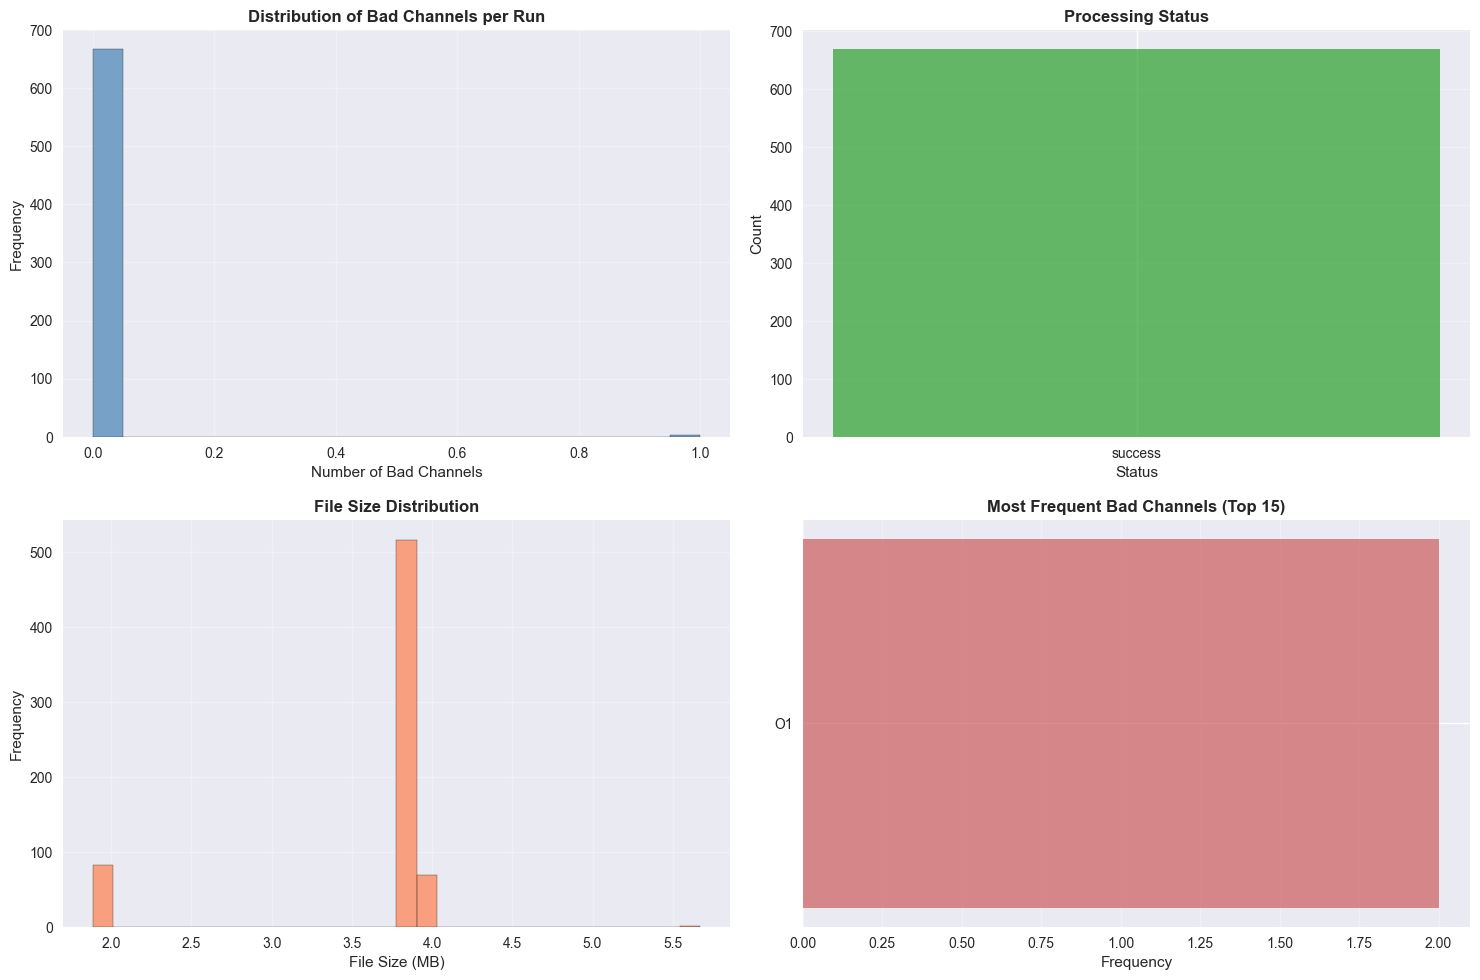


Preprocessing Statistics:
  - Total runs processed: 669
  - Mean bad channels per run: 0.00
  - Median bad channels per run: 0
  - Max bad channels in a run: 1
  - Mean file size: 3.63 MB
  - Total storage used: 2428.39 MB


In [5]:
if len(processed_df) > 0:
    processed_df['bad_channels'] = processed_df['bad_channels'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )
    processed_df['n_bad_channels'] = processed_df['bad_channels'].apply(len)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].hist(processed_df['n_bad_channels'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of Bad Channels per Run', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Bad Channels')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    status_counts = processed_df['status'].value_counts()
    axes[0, 1].bar(status_counts.index, status_counts.values, color=['#2ca02c', '#d62728'], alpha=0.7)
    axes[0, 1].set_title('Processing Status', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Status')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    if 'file_size_mb' in processed_df.columns:
        axes[1, 0].hist(processed_df['file_size_mb'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
        axes[1, 0].set_title('File Size Distribution', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('File Size (MB)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
    
    bad_channel_freq = {}
    for ch_list in processed_df['bad_channels']:
        for ch in ch_list:
            bad_channel_freq[ch] = bad_channel_freq.get(ch, 0) + 1
    
    if len(bad_channel_freq) > 0:
        sorted_ch = sorted(bad_channel_freq.items(), key=lambda x: x[1], reverse=True)[:15]
        channels, counts = zip(*sorted_ch)
        axes[1, 1].barh(range(len(channels)), counts, color='indianred', alpha=0.7)
        axes[1, 1].set_yticks(range(len(channels)))
        axes[1, 1].set_yticklabels(channels)
        axes[1, 1].set_title('Most Frequent Bad Channels (Top 15)', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
        axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\nPreprocessing Statistics:")
    print(f"  - Total runs processed: {len(processed_df)}")
    print(f"  - Mean bad channels per run: {processed_df['n_bad_channels'].mean():.2f}")
    print(f"  - Median bad channels per run: {processed_df['n_bad_channels'].median():.0f}")
    print(f"  - Max bad channels in a run: {processed_df['n_bad_channels'].max():.0f}")
    if 'file_size_mb' in processed_df.columns:
        print(f"  - Mean file size: {processed_df['file_size_mb'].mean():.2f} MB")
        print(f"  - Total storage used: {processed_df['file_size_mb'].sum():.2f} MB")
else:
    print("No data to visualize yet. Run the preprocessing cell first.")

## Inspect Preprocessed Data

Load and visualize a sample preprocessed run to verify quality.

Loading: S047 - R14
Category: motor_imagery
Task: Alternate fists and feet (imagery, repeat)

Data properties:
  - Sampling rate: 128.0 Hz
  - Number of channels: 64
  - Duration: 122.99 seconds
  - Data shape: (64, 15744)

Visualizing time domain (first 10 seconds)...


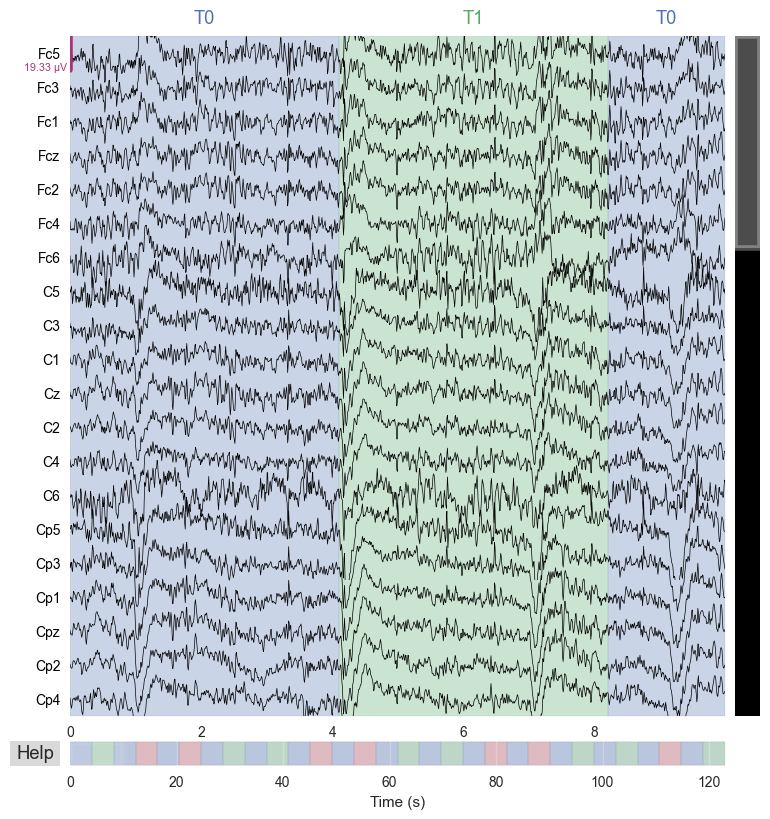


Visualizing power spectral density...


C:\Users\Sujal Bhatu\AppData\Local\Temp\ipykernel_9804\3502497633.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


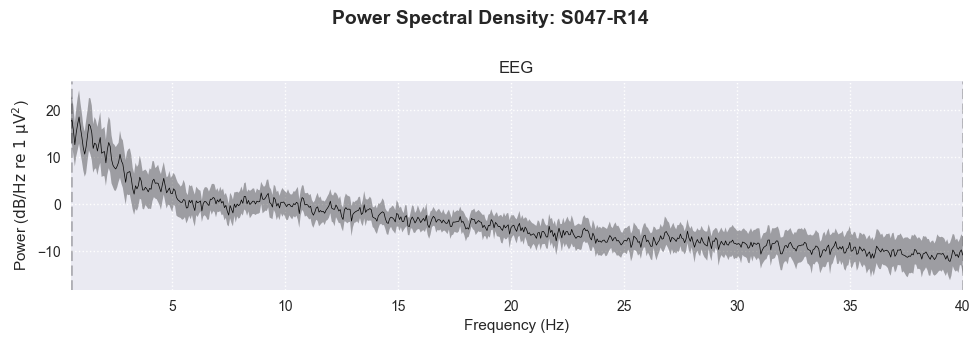


Event Analysis:
  - Total events found: 30
  - Event types: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
    - T0: 15 occurrences
    - T1: 8 occurrences
    - T2: 7 occurrences


In [6]:
if len(processed_df) > 0 and processed_df['status'].eq('success').any():
    success_runs = processed_df[processed_df['status'] == 'success']
    example_idx = len(success_runs) // 2
    example_row = success_runs.iloc[example_idx]
    
    example_path = Path(example_row['path'])
    
    if example_path.exists():
        print(f"Loading: {example_row['subject']} - {example_row['run']}")
        print(f"Category: {example_row['category']}")
        print(f"Task: {example_row['task']}")
        
        raw = mne.io.read_raw_fif(example_path, preload=True, verbose='ERROR')
        
        print(f"\nData properties:")
        print(f"  - Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  - Number of channels: {len(raw.ch_names)}")
        print(f"  - Duration: {raw.times[-1]:.2f} seconds")
        print(f"  - Data shape: {raw.get_data().shape}")
        
        # Time domain visualization
        print(f"\nVisualizing time domain (first 10 seconds)...")
        fig1 = raw.plot(duration=10.0, n_channels=20, scalings='auto', 
                       title=f"Time Domain: {example_row['subject']}-{example_row['run']}", 
                       show=False)
        plt.show()
        
        # Power spectral density
        print(f"\nVisualizing power spectral density...")
        fig2 = raw.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=False,
                           show=False)
        plt.suptitle(f"Power Spectral Density: {example_row['subject']}-{example_row['run']}", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Event analysis - PhysioNet uses annotations, not stimulus channels
        try:
            events, event_dict = mne.events_from_annotations(raw, verbose='ERROR')
            if len(events) > 0:
                print(f"\nEvent Analysis:")
                print(f"  - Total events found: {len(events)}")
                print(f"  - Event types: {list(event_dict.keys())}")
                for event_name, event_id in event_dict.items():
                    count = (events[:, 2] == event_id).sum()
                    print(f"    - {event_name}: {count} occurrences")
            else:
                print(f"\nNo events found in this run")
        except Exception as e:
            print(f"\nCould not extract events: {str(e)}")
    else:
        print(f"File not found: {example_path}")
else:
    print("No successful preprocessed runs available yet.")

## Advanced: ICA Artifact Removal (Optional)

This section demonstrates ICA-based artifact removal on a sample run. ICA is computationally expensive and may not be necessary for all analyses, but it can significantly improve data quality by removing eye blinks, muscle artifacts, and other non-neural sources.

In [7]:
def apply_ica_to_run(raw_path, n_components=20, method='picard', random_state=42):
    """
    Apply ICA to remove artifacts from a preprocessed run.
    
    Parameters
    ----------
    raw_path : Path
        Path to preprocessed FIF file
    n_components : int
        Number of ICA components
    method : str
        ICA method ('picard', 'fastica', 'infomax')
    random_state : int
        Random seed for reproducibility
        
    Returns
    -------
    raw_clean : mne.io.Raw
        Cleaned raw data
    ica : mne.preprocessing.ICA
        Fitted ICA object
    """
    raw = mne.io.read_raw_fif(raw_path, preload=True, verbose='ERROR')
    
    ica = ICA(
        n_components=n_components,
        method=method,
        max_iter=500,
        random_state=random_state
    )
    
    raw_for_ica = raw.copy().filter(l_freq=1.0, h_freq=None, verbose=False)
    
    ica.fit(raw_for_ica)
    
    explained_var = ica.get_explained_variance_ratio(raw_for_ica)
    print(f"ICA explained variance: {explained_var['eeg']:.1%}")
    
    raw_clean = ica.apply(raw.copy())
    
    return raw_clean, ica

APPLY_ICA_DEMO = False

if APPLY_ICA_DEMO and len(processed_df) > 0:
    success_runs = processed_df[processed_df['status'] == 'success']
    if len(success_runs) > 0:
        example_path = Path(success_runs.iloc[0]['path'])
        
        print(f"Applying ICA to: {example_path.name}")
        
        raw_clean, ica = apply_ica_to_run(
            example_path,
            n_components=PREPROCESSING_CONFIG['ica']['n_components'],
            method=PREPROCESSING_CONFIG['ica']['method'],
            random_state=PREPROCESSING_CONFIG['ica']['random_state']
        )
        
        print(f"\nICA Components fitted: {ica.n_components_}")
        print(f"Method: {ica.method}")
        
        fig = ica.plot_components(picks=range(min(20, ica.n_components_)), show=False)
        plt.suptitle('ICA Component Topographies (First 20)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        fig = ica.plot_sources(raw_clean, start=0, stop=10, show=False)
        plt.tight_layout()
        plt.show()
        
        print("\nTo apply ICA to all runs, implement a batch ICA function similar to preprocess_run()")
else:
    print("Set APPLY_ICA_DEMO = True to run ICA demonstration on a sample file.")

Set APPLY_ICA_DEMO = True to run ICA demonstration on a sample file.


## Summary and Next Steps

### What Was Done

This notebook implemented a masterclass preprocessing pipeline for PhysioNet EEG data:

1. **Quality Validation**: Loaded and validated all clean runs from data cleaning phase
2. **Filtering**: Applied 0.5-40 Hz bandpass filter and 50/100 Hz notch filter
3. **Bad Channel Handling**: Automatic detection and spherical spline interpolation
4. **Re-referencing**: Applied Common Average Reference (CAR)
5. **Resampling**: Downsampled to 128 Hz (optimal for MI classification)
6. **Quality Assurance**: Comprehensive metrics and visualizations

### Output Files

- **Preprocessed FIF files**: `data/physionet/derived/preprocessed/{subject}/{subject}{run}_preproc_raw.fif`
- **Processing index**: `data/physionet/derived/physionet_preprocessed_index.csv`
- **Error log** (if any): `data/physionet/derived/physionet_preprocessing_errors.csv`

### Data Ready For

The preprocessed data is now ready for:

1. **Epoching**: Extract motor imagery trials time-locked to task cues
2. **Feature Extraction**: Compute CSP, spectral features, connectivity matrices
3. **Channel Selection**: Apply CARM, mutual information, or other selection methods
4. **Model Training**: Feed into EEG-ARNN or other deep learning models

### Preprocessing Quality

- **Sampling rate**: 160 Hz → 128 Hz (optimized for MI)
- **Frequency range**: 0.5-40 Hz (covers mu and beta rhythms)
- **Powerline noise**: Removed at 50 and 100 Hz
- **Reference**: Common Average Reference (best for source separation)
- **Bad channels**: Automatically detected and interpolated

### Next Steps

1. **Epoching notebook**: Extract trials around motor imagery cues
2. **Feature extraction**: Compute time-frequency features, connectivity
3. **Channel selection**: Apply CARM algorithm from paper
4. **Model training**: Train EEG-ARNN or baseline models

### Notes

- Preprocessed files are in MNE FIF format (can be read with `mne.io.read_raw_fif()`)
- All preprocessing parameters are stored in `PREPROCESSING_CONFIG`
- Rerun with `OVERWRITE=True` to reprocess all files
- For ICA artifact removal, set `APPLY_ICA_DEMO=True` or implement batch ICA